# SURE 2024 Speedy Simulations Kickoff
## Kernel Density Estimation with Quasi-Monte Carlo Methods

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### Those involved in this project are
- Fred J. Hickernell
- [add your names here]
- Aiwen Li
- Richard Varela

### If you are running this on colab, run this cell below
### If you running this in Jupyter notebook and you have the environment set up, ignore this cell below

In [ ]:
# If you are running this on colab
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

### Import needed packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

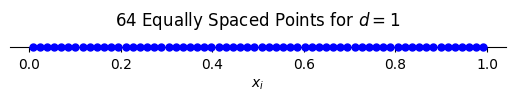

In [2]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), 'b.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [2]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


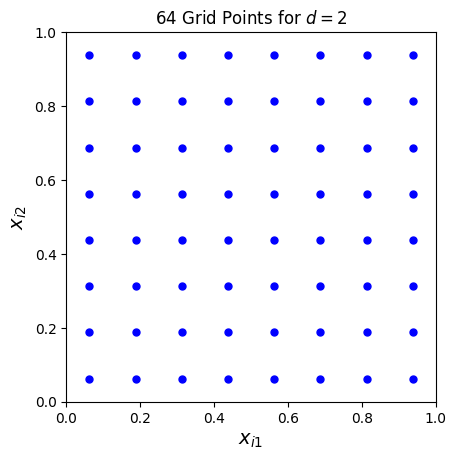

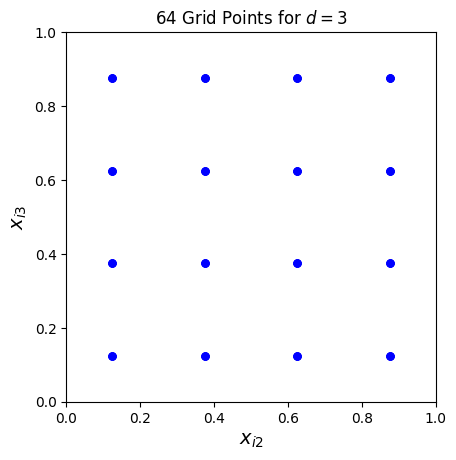

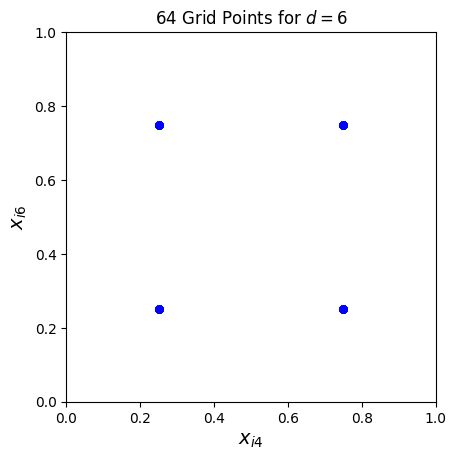

In [4]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

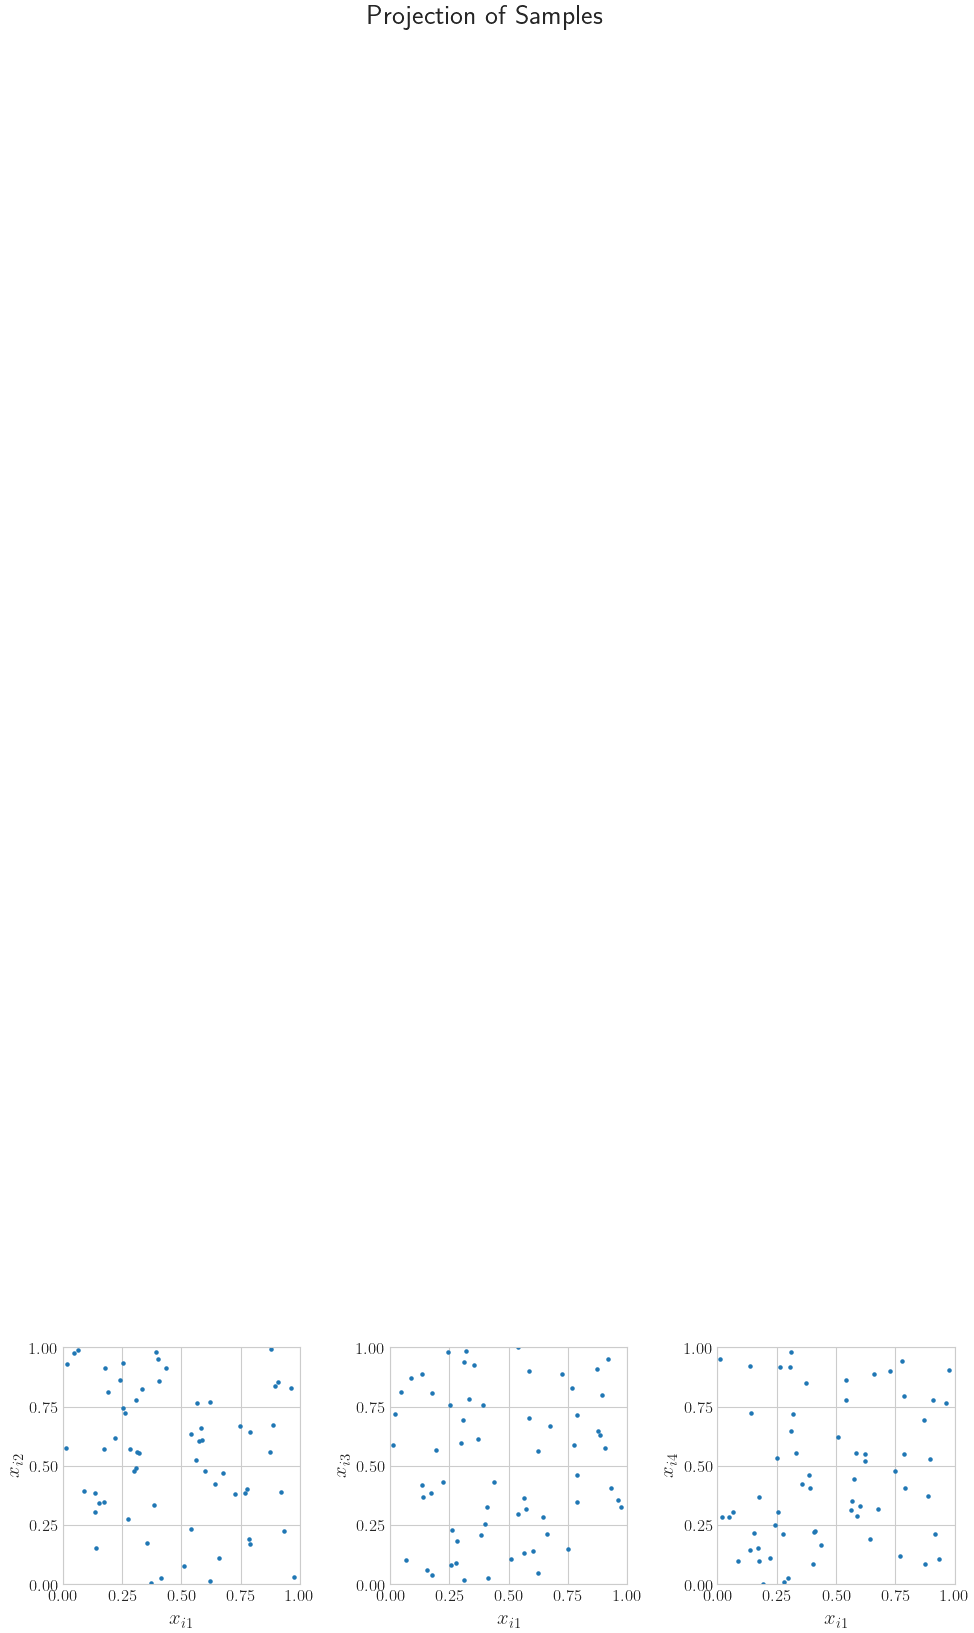

In [5]:
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

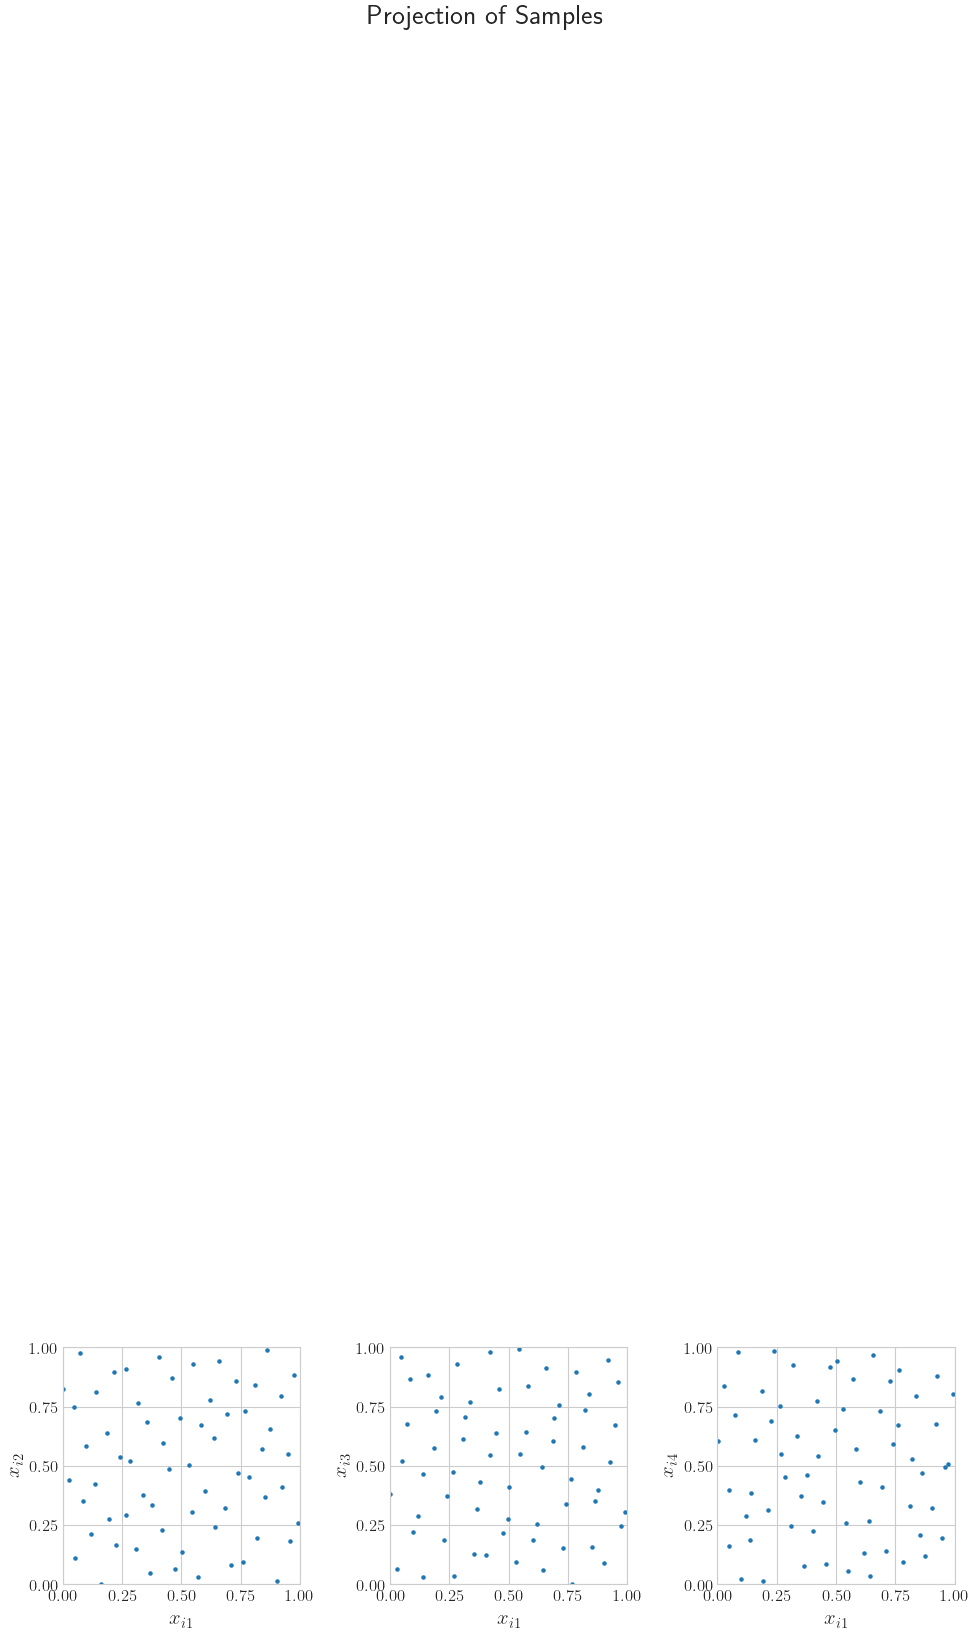

In [7]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Kernel Density Estimation

### Gaussian kernel

In [3]:
def kernel(y):
    return np.exp(-y*y)/np.sqrt(np.pi)

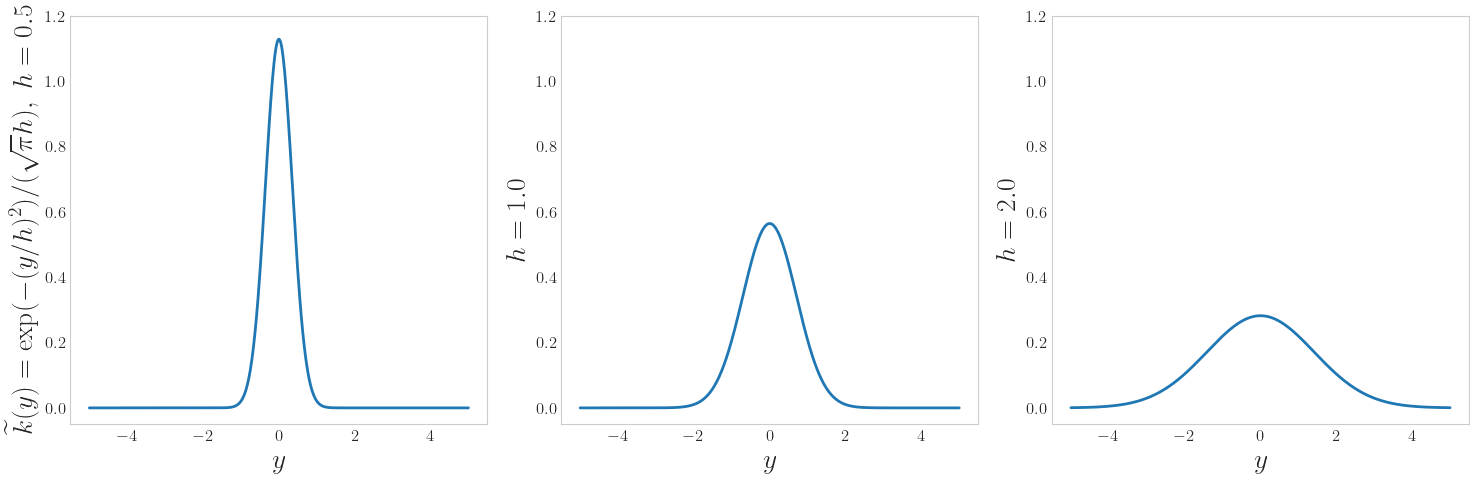

In [8]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.05, 1.2])
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
if savefigs:
        fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

### Numerical experiment

#### Generate some $\vx_i$

In [15]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.82761378 0.62416944 0.35131621]
 [0.59495142 0.70140062 0.160702  ]
 [0.99618471 0.98212598 0.98287632]
 ...
 [0.29962899 0.71189447 0.93500731]
 [0.77178634 0.63751465 0.38601694]
 [0.843211   0.20344544 0.63433603]]
[[0.82761378 0.31208472 0.08782905]
 [0.59495142 0.35070031 0.0401755 ]
 [0.99618471 0.49106299 0.24571908]
 ...
 [0.29962899 0.35594724 0.23375183]
 [0.77178634 0.31875732 0.09650423]
 [0.843211   0.10172272 0.15858401]]
sobol pts [[0.17430326 0.81639927 0.77124195]
 [0.83707805 0.37023496 0.27062994]
 [0.39986022 0.14649094 0.01902441]
 ...
 [0.91787297 0.24099929 0.01682113]
 [0.35519764 0.27719074 0.27283728]
 [0.62591027 0.78438985 0.77296017]]


#### Generate some $y_i=f(x_i)$ points
$
f(\vx) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [20]:
def testfun1(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [21]:
yiid1 = testfun1(iidpts)
ysob1 = testfun1(sobpts)

#### Construct a kernel density estimator

In [18]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

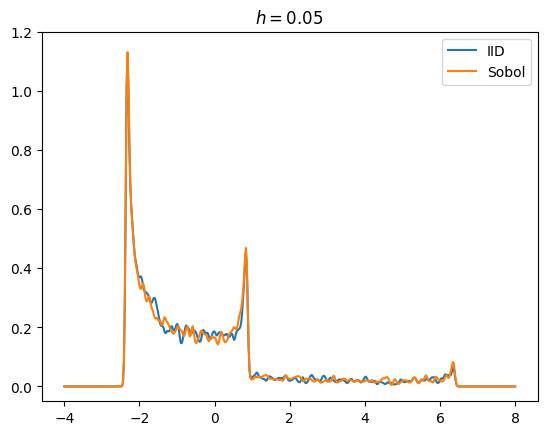

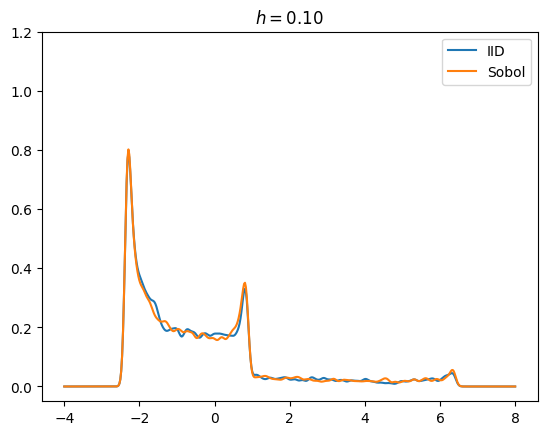

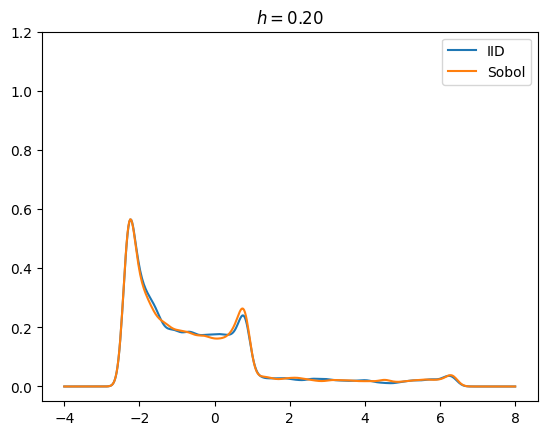

In [22]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Kernel density estimator for uniform distribution

In [23]:
def testfun_unif(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [24]:
yiid_unif = testfun_unif(iidpts)
ysob_unif = testfun_unif(sobpts)

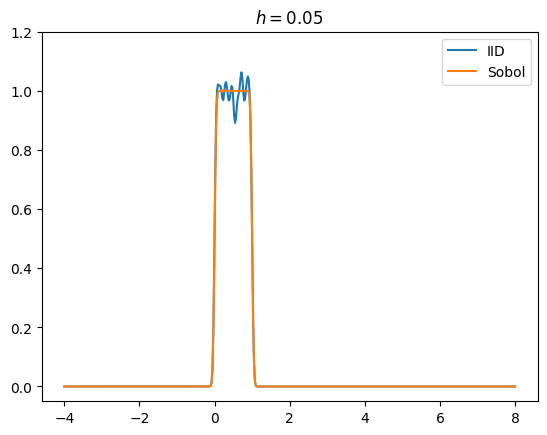

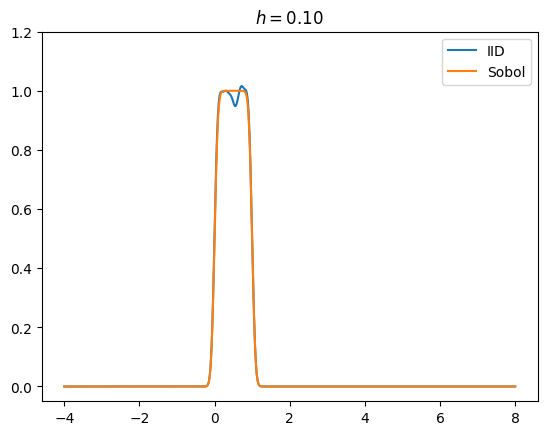

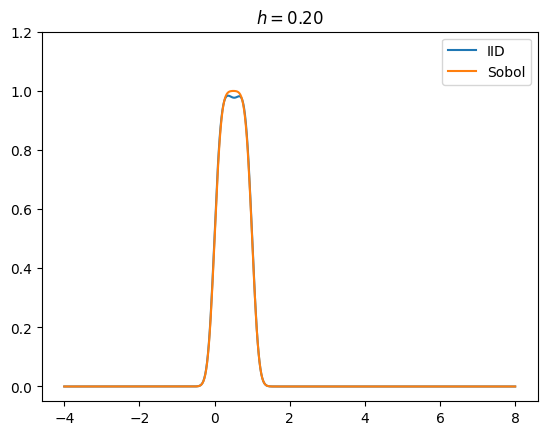

In [25]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_unif,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_unif,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Testing different bandwidths

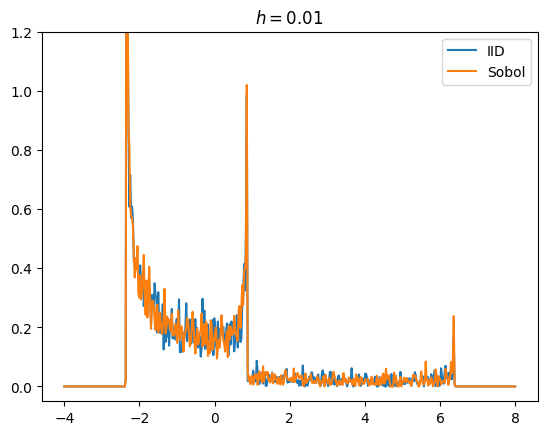

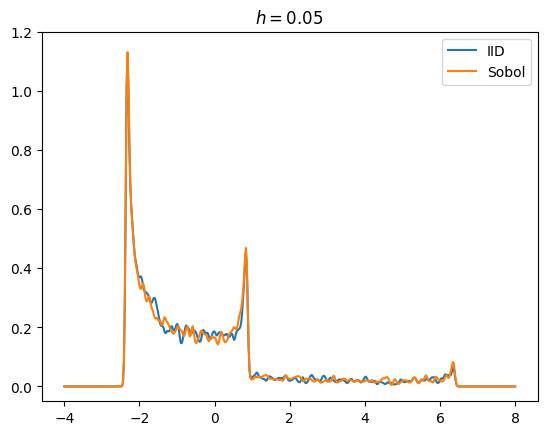

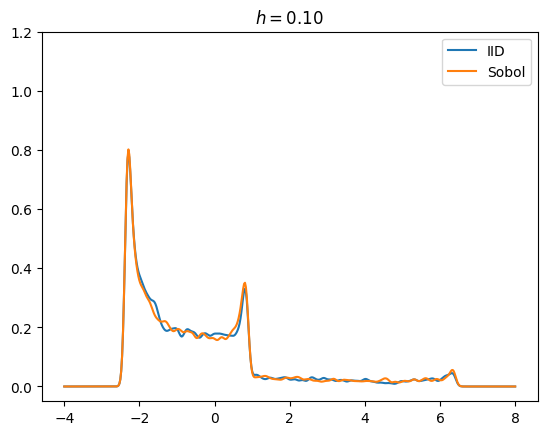

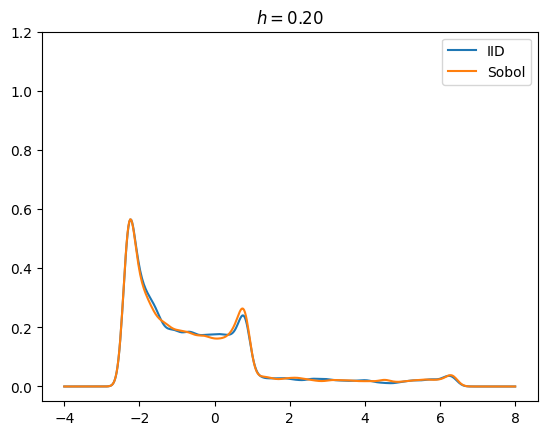

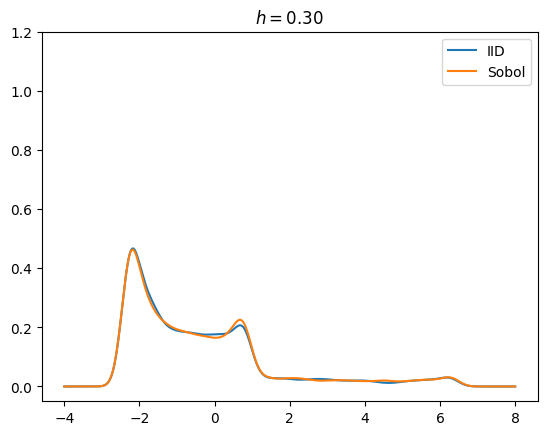

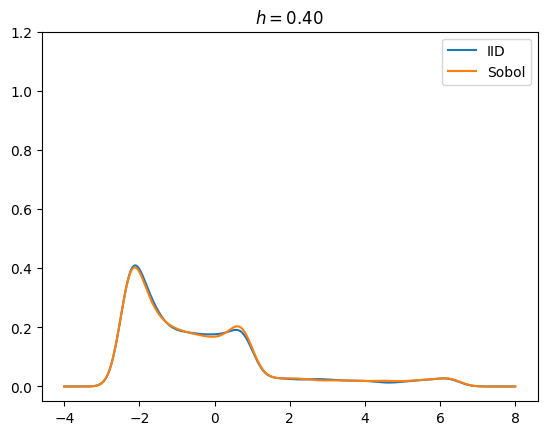

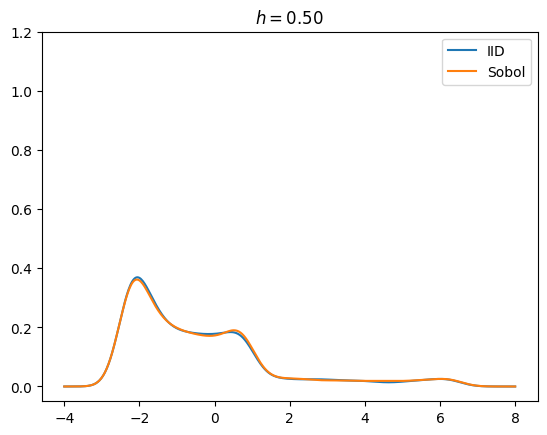

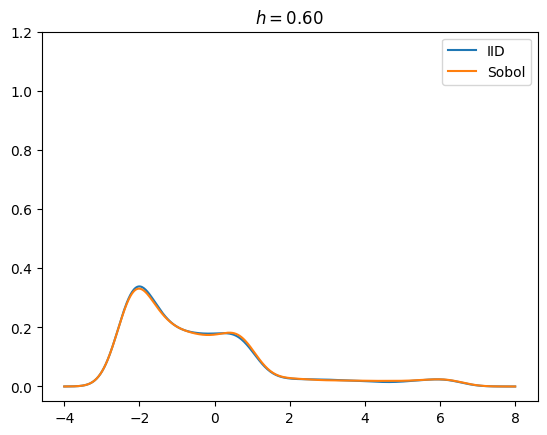

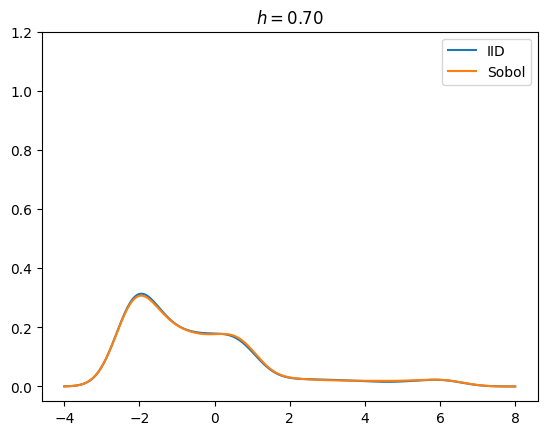

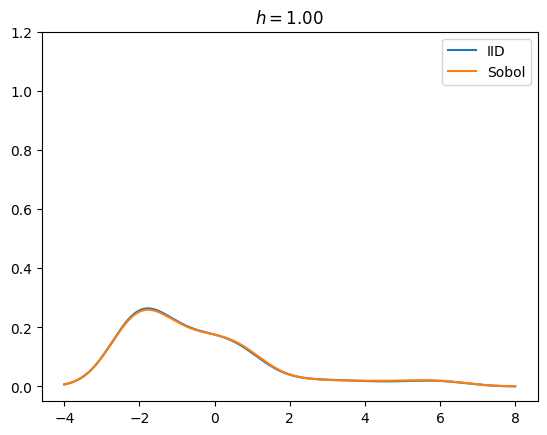

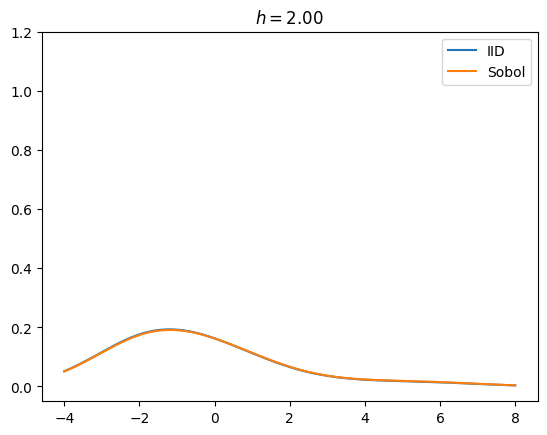

In [27]:
## testing diff. bandwidths--original f(x)

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

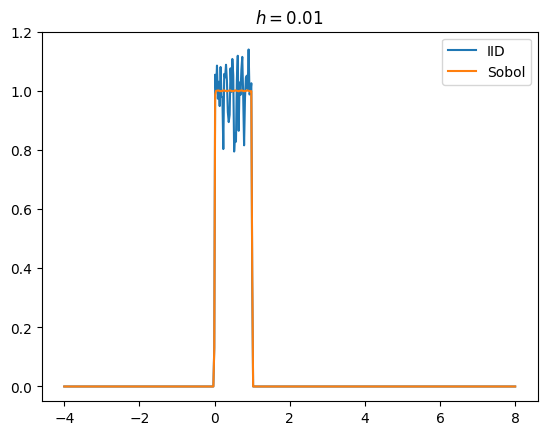

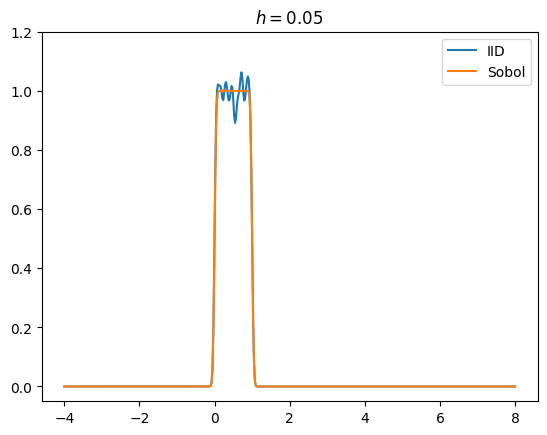

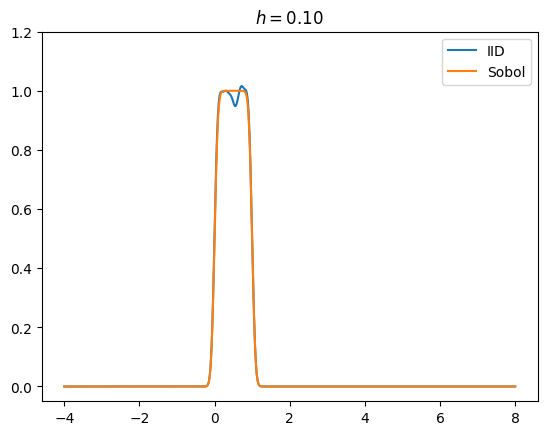

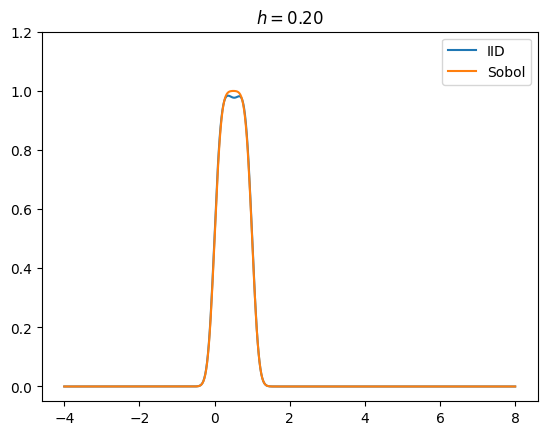

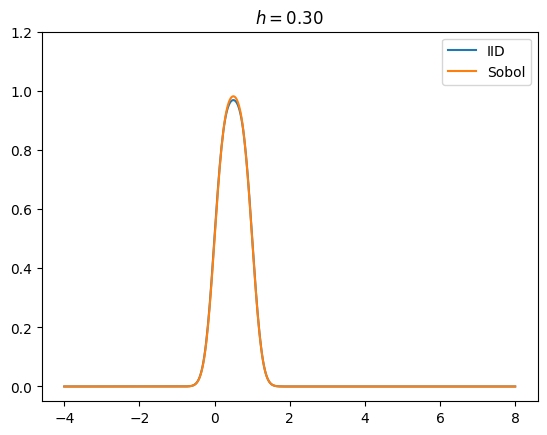

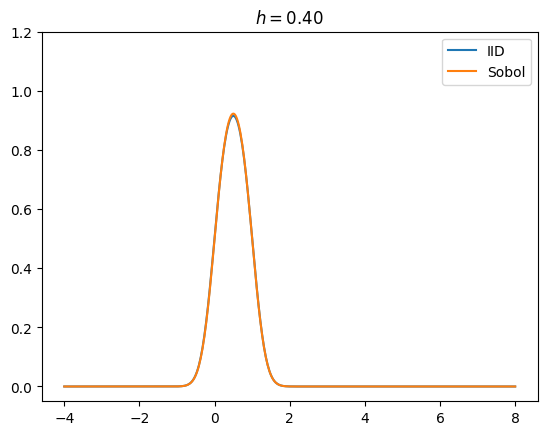

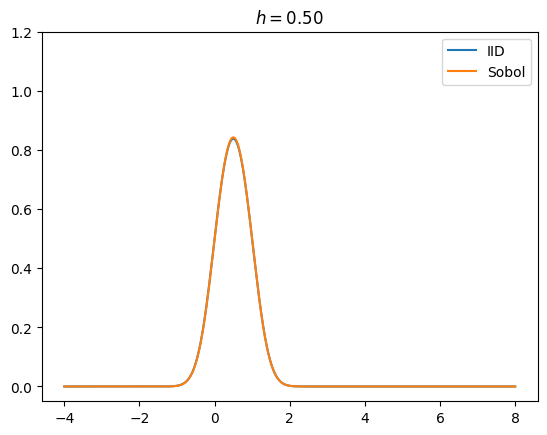

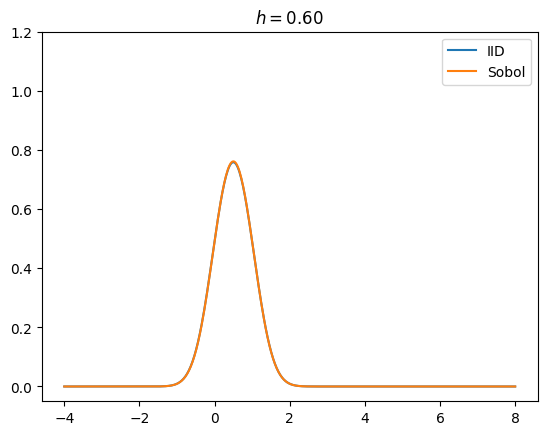

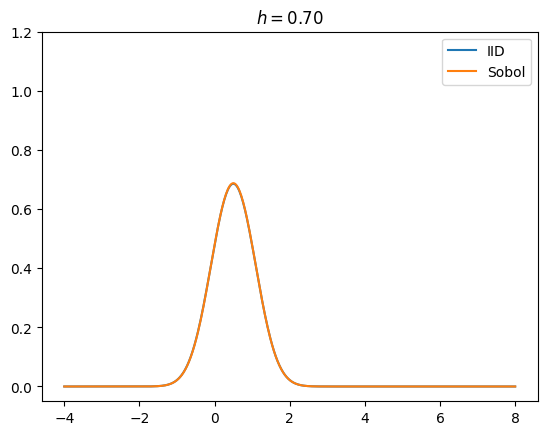

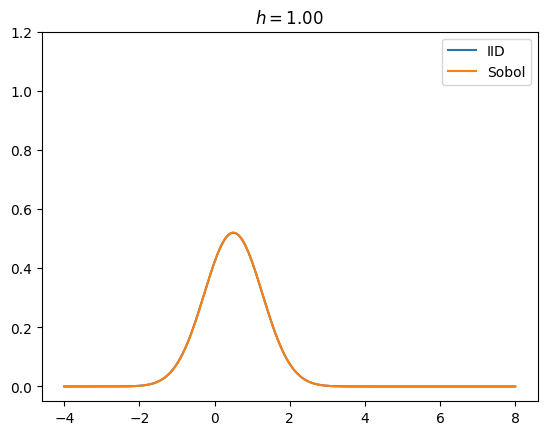

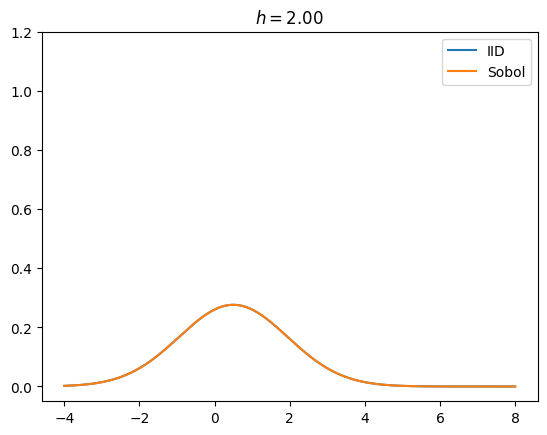

In [26]:
## testing diff. bandwidths--uniform

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_unif,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_unif,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [28]:
## testing different LD generators

d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)
latticepts = qp.Lattice(d).gen_samples(n)
print("lattice pts",latticepts)
dnetb2pts = qp.DigitalNetB2(d).gen_samples(n)
print("Digital Net B2 pts",dnetb2pts)
haltonpts = qp.Halton(d).gen_samples(n)
print("halton pts",haltonpts)

iid pts [[0.73463915 0.88339686 0.31840967]
 [0.76135423 0.13424977 0.6858724 ]
 [0.87161801 0.24957659 0.0194861 ]
 ...
 [0.24384507 0.11430539 0.30666281]
 [0.1473264  0.43893829 0.07235696]
 [0.3719283  0.21833746 0.71845017]]
[[0.73463915 0.44169843 0.07960242]
 [0.76135423 0.06712489 0.1714681 ]
 [0.87161801 0.1247883  0.00487153]
 ...
 [0.24384507 0.05715269 0.0766657 ]
 [0.1473264  0.21946914 0.01808924]
 [0.3719283  0.10916873 0.17961254]]
sobol pts [[0.41447624 0.2478833  0.48114984]
 [0.90210933 0.71422892 0.84797088]
 [0.23305161 0.79792144 0.51065707]
 ...
 [0.86401959 0.82977432 0.50845962]
 [0.00161013 0.68358173 0.8496798 ]
 [0.54886217 0.15377456 0.48334705]]
lattice pts [[0.79040425 0.60593533 0.61079024]
 [0.29040425 0.10593533 0.11079024]
 [0.04040425 0.35593533 0.36079024]
 ...
 [0.54016011 0.25949978 0.14130782]
 [0.29016011 0.50949978 0.39130782]
 [0.79016011 0.00949978 0.89130782]]
Digital Net B2 pts [[0.47810536 0.54222928 0.67139723]
 [0.96728694 0.18516386 0.4

In [29]:
# using original function f(x)

yiid1 = testfun1(iidpts)
ysob1 = testfun1(sobpts)
ylattice1 = testfun1(latticepts)
ydnetb21 = testfun1(dnetb2pts)
yhalton1 = testfun1(haltonpts)

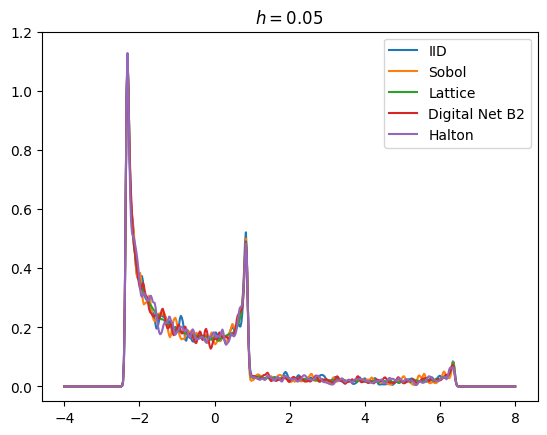

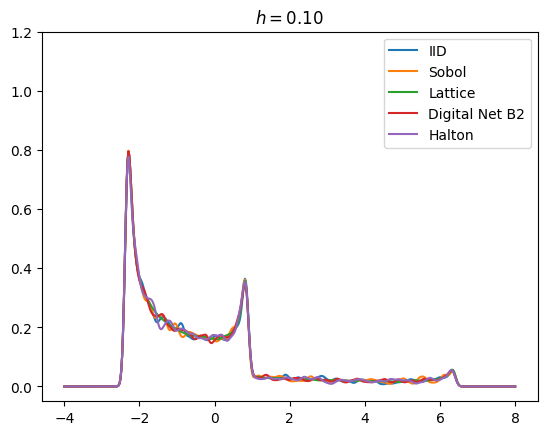

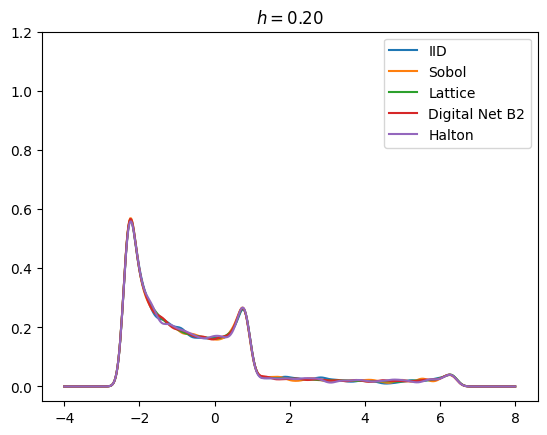

In [32]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1,bandwidth[ii],yeval)
    rhovallattice = kde(kernel,ylattice1,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel,ydnetb21,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel,yhalton1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Testing different functions for f(x)

#### Testing different kernels